## Bingham Rotation Learning Demo
Demo requires `lrcurve`: `pip install lrcurve`.

In [6]:
import torch
import numpy as np
from networks import *
from losses import *
from helpers_sim import *
import argparse

Create a parser object with our desired settings:

In [19]:
parser = argparse.ArgumentParser(description='Synthetic Wahba arguments.')
parser.add_argument('--sim_sigma', type=float, default=1e-2)
parser.add_argument('--N_train', type=int, default=5000)
parser.add_argument('--N_test', type=int, default=100)
parser.add_argument('--matches_per_sample', type=int, default=100)

parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--batch_size_train', type=int, default=50)
parser.add_argument('--batch_size_test', type=int, default=100)
parser.add_argument('--lr', type=float, default=5e-4)

parser.add_argument('--dataset', choices=['static', 'dynamic', 'dynamic_beachball'], default='dynamic_beachball')
parser.add_argument('--beachball_sigma_factors', type=lambda s: [float(item) for item in s.split(',')], default=[0.1, 0.5, 2, 10], help='Heteroscedastic point cloud that has different noise levels (resembling a beachball).')
parser.add_argument('--max_rotation_angle', type=float, default=180., help='In degrees. Maximum axis-angle rotation of simulated rotation.')

parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--double', action='store_true', default=False)
parser.add_argument('--enforce_psd', action='store_true', default=False)
parser.add_argument('--unit_frob', action='store_true', default=False)

args = parser.parse_args([])
print(args)

Namespace(sim_sigma=0.01, N_train=5000, N_test=100, matches_per_sample=100, epochs=50, batch_size_train=50, batch_size_test=100, lr=0.0005, dataset='dynamic_beachball', beachball_sigma_factors=[0.1, 0.5, 2, 10], max_rotation_angle=180.0, cuda=False, double=False, enforce_psd=False, unit_frob=False)


Specify the device to use while training

In [20]:
device = torch.device('cuda:0') if args.cuda else torch.device('cpu')
tensor_type = torch.double if args.double else torch.float

Generate the training and test data

In [15]:
if args.dataset == 'static':
    train_data, test_data = create_experimental_data_fast(args.N_train, args.N_test, args.matches_per_sample,
                                                          sigma=args.sim_sigma, device=device, dtype=tensor_type)
else:
    #Data will be generated on the fly
    train_data, test_data = None, None

In [16]:
train_data

# Our Representation
Define our Bingham distribution model with `symeig`. This is all that is required for our approach.

In [21]:
#Input: 10 numbers that defines a symmetric 4x4 matrix
#Output: unit 4-vector defining unit-quaternion
def A_vec_to_quat(A_vec):
    A = convert_Avec_to_A(A_vec)
    #_, evs = torch.symeig(A, eigenvectors=True)
    _, evs = torch.linalg.eigh(A)
    return evs[:,:,0].squeeze()

#Basic example
class BinghamNetDemo(torch.nn.Module):
    def __init__(self):
        super(BinghamNetDemo, self).__init__()
        self.A_net = PointNet(dim_out=10, normalize_output=False, batchnorm=False)

    def output_A(self, x):
        A_vec = self.A_net(x)
        return convert_Avec_to_A(A_vec)

    def forward(self, x):
        A_vec = self.A_net(x)
        q = A_vec_to_quat(A_vec)
        return q

Set up the cost function and model for our approach and the 2 baselines

In [22]:
model_quat = PointNet(dim_out=4, normalize_output=True).to(device=device, dtype=tensor_type)
loss_fn_quat = quat_chordal_squared_loss

model_6D = RotMat6DDirect().to(device=device, dtype=tensor_type)
loss_fn_6D = rotmat_frob_squared_norm_loss

#model_bingham = QuatNet(enforce_psd=args.enforce_psd, unit_frob_norm=args.unit_frob).to(device=device, dtype=tensor_type)
model_bingham = BinghamNetDemo()
loss_fn_bingham = quat_chordal_squared_loss

Train the models on the same data

In [23]:
models = [model_quat, model_6D, model_bingham]
losses = [loss_fn_quat, loss_fn_6D, loss_fn_bingham]
rotmat_targets = [False, True, False]
train_test_models_with_plots(args, train_data, test_data, models, losses, rotmat_targets=rotmat_targets)

In [1]:
from helpers_sim import *
train_data, test_data = create_experimental_data_fast(beachball=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import matplotlib.pyplot as plt
import mplcursors


def points_visualization(clusters):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Generate random colors and markers for each cluster
    colors = [np.random.rand(3,) for _ in range(len(clusters))]
    markers = ['o', 's', '^', 'D', 'x', '+', '*', 'p', 'h', '<', '>']  # You can add more markers if needed

    for i, cluster_points in enumerate(clusters):
        # Generate random color and marker for this cluster
        color = colors[i]
        marker = np.random.choice(markers)

        # Scatter plot for this cluster
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], c=[color], marker=marker, label=f'Cluster {i+1}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Cluster Visualization')
    ax.legend()
    
    # Add interactivity with mplcursors
    mplcursors.cursor(hover=True)

    plt.show()


In [3]:
clusters = [train_data.x[0][0].numpy(), train_data.x[0][1].numpy()]

In [4]:
%matplotlib inline

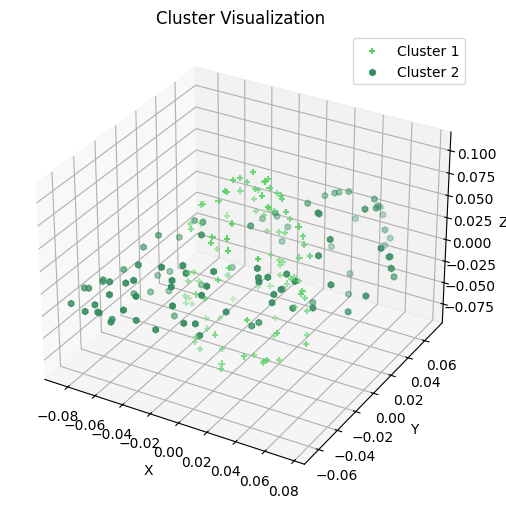

In [5]:
points_visualization(clusters)

In [ ]:
train_data.x[0][0].numpy().shape